[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 1174/1174 [05:02<00:00,  3.88it/s]


Epoch 1/1, Loss: 0.1669

Validation Metrics:
Accuracy: 0.949520766773163
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      4264
         1.0       0.77      0.64      0.70       431

    accuracy                           0.95      4695
   macro avg       0.87      0.81      0.84      4695
weighted avg       0.95      0.95      0.95      4695

AUC: 0.9582189745911381


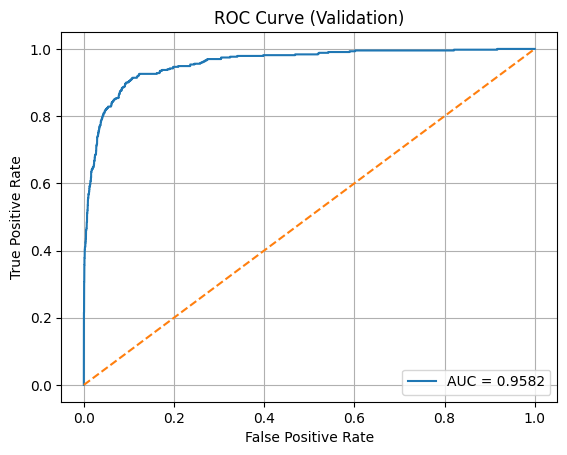


✅ Multilingual BERT model completed. Predictions saved as 'bert_predictions.csv'

Test Set Metrics:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       839
           1       1.00      1.00      1.00         1

    accuracy                           1.00       840
   macro avg       1.00      1.00      1.00       840
weighted avg       1.00      1.00      1.00       840

AUC: 1.0


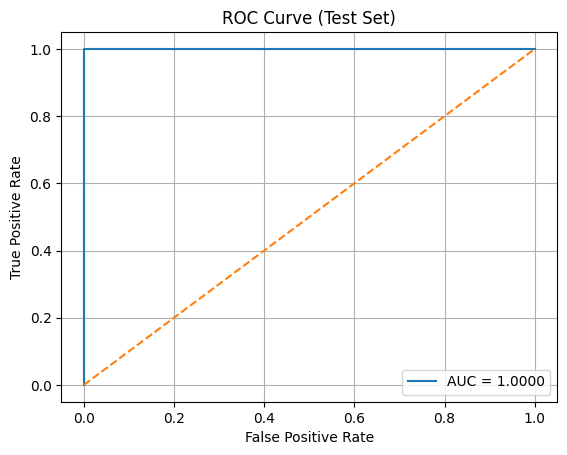

In [2]:
# model2_implementation.ipynb

# ================================
# Offensive Language Classification - Model 2 (Transformer)
# Multilingual BERT Fine-Tuning (toxic label only)
# ================================

# Imports
import pandas as pd
import numpy as np
import torch
from torch.optim import AdamW

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import  get_scheduler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# ================================
# Preprocessing Function
# ================================
stop_words_en = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#','', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words_en]
    return " ".join(tokens)

# ================================
# Load and preprocess data
# ================================
train_df = pd.read_csv("../offence_data/train.csv") 
test_df = pd.read_csv("../offence_data/validation.csv") 

train_df['feedback_text'] = train_df['feedback_text'].apply(preprocess)
test_df['feedback_text'] = test_df['feedback_text'].apply(preprocess)

# Only using 'toxic' label
train_df = train_df[['feedback_text', 'toxic']]
test_df = test_df[['id', 'feedback_text']]

# ================================
# Tokenization and Dataset
# ================================
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

class ToxicDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Split dataset
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['feedback_text'].tolist(),
    train_df['toxic'].tolist(),
    test_size=0.2,
    random_state=42
)

train_dataset = ToxicDataset(train_texts, train_labels)
val_dataset = ToxicDataset(val_texts, val_labels)

test_dataset = ToxicDataset(test_df['feedback_text'].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# ================================
# Model
# ================================
class ToxicClassifier(nn.Module):
    def __init__(self):
        super(ToxicClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return torch.sigmoid(self.fc(output))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ToxicClassifier().to(device)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 1
total_steps = len(train_loader) * epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.BCELoss()

# ================================
# Training
# ================================
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask).squeeze()
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# ================================
# Evaluation on validation set
# ================================
model.eval()
preds, trues = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        outputs = model(input_ids, attention_mask).squeeze().cpu().numpy()
        preds.extend(outputs)
        trues.extend(labels)

# Binarize predictions
bin_preds = [1 if p >= 0.5 else 0 for p in preds]

print("\nValidation Metrics:")
print("Accuracy:", accuracy_score(trues, bin_preds))
print(classification_report(trues, bin_preds))
print("AUC:", roc_auc_score(trues, preds))

# Plot AUC-ROC
fpr, tpr, _ = roc_curve(trues, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation)')
plt.legend()
plt.grid()
plt.show()

# ================================
# Test Predictions + Evaluation
# ================================
model.eval()
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask).squeeze().cpu().numpy()
        test_preds.extend(outputs)

final_preds = [1 if p >= 0.5 else 0 for p in test_preds]
test_df['toxic'] = final_preds

# Save submission
submission = test_df[['id', 'toxic']]
submission.to_csv("bert_predictions.csv", index=False)

print("\n✅ Multilingual BERT model completed. Predictions saved as 'bert_predictions.csv'")

# Optional: If true test labels exist, calculate metrics
if 'toxic' in test_df.columns:
    print("\nTest Set Metrics:")
    print("Accuracy:", accuracy_score(test_df['toxic'], final_preds))
    print(classification_report(test_df['toxic'], final_preds))
    print("AUC:", roc_auc_score(test_df['toxic'], test_preds))

    fpr, tpr, _ = roc_curve(test_df['toxic'], test_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test Set)')
    plt.legend()
    plt.grid()
    plt.show()


In [5]:
import pandas as pd
import numpy as np
import torch
from torch.optim import AdamW

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import  get_scheduler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print("Accuracy:", accuracy_score(test_df['toxic'], final_preds))

In [3]:
final_preds

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
